<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sqlite3 Database & Helper Classes

In [32]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)  # 'execute' for 1 statement 'executescript' for many
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [33]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, workout] #ready

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """

  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)

Load tables from database into Pandas dataframe object

In [34]:
db_path = r"/"
driver = CSVDriver(db_path) 

# R.srl_normalized_score, R.hrv_normalized_score,
sel_query = """
SELECT S.composition_score, S.revitalization_score, S.duration_score,
       S.deep_sleep_in_minutes, S.resting_heart_rate, S.restlessness,    
       W.notes AS rpe     
FROM t_sleep S
LEFT JOIN t_workout W
ON S.timestamp = W.date
AND TRIM(W.score_type) != 'Load';
"""
data = pd.DataFrame.from_records(driver.query(sel_query))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       392 non-null    int64  
 1   1       392 non-null    int64  
 2   2       392 non-null    int64  
 3   3       392 non-null    int64  
 4   4       392 non-null    int64  
 5   5       392 non-null    float64
 6   6       300 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 21.6+ KB
None


Data Prep => extract @RPE and fillna w/ baseline

In [35]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data['rpe'] = data[6].str.extract(r'(@RPE+\d+)', expand=False)
data['rpe'] = data['rpe'].str[4:].astype(float)
# Fill all nan rpe with random rpe using mean and stdev
rng = np.random.default_rng(0)
mu = int(data['rpe'].mean())
sd = int(data['rpe'].std())

filler = pd.Series(rng.normal(loc=mu, scale=sd, size=len(data)))
data['rpe'] = data['rpe'].fillna(filler)
# data=data.fillna({'rpe':3.0}) # moderate, @130bpm HR
data.drop(columns=[6], inplace=True)

dict_col_names = {
    0: 'comp_score',
    1: 'revitalize_score',
    2: 'duration_score', 
    3: 'deep_sleep',
    4: 'resting_hr',
    5: 'restlessness',
}

data.rename(dict_col_names, axis=1, inplace=True)
print(data.info())
print(data.head())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comp_score        392 non-null    int64  
 1   revitalize_score  392 non-null    int64  
 2   duration_score    392 non-null    int64  
 3   deep_sleep        392 non-null    int64  
 4   resting_hr        392 non-null    int64  
 5   restlessness      392 non-null    float64
 6   rpe               392 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 21.6 KB
None
   comp_score  revitalize_score  duration_score  deep_sleep  resting_hr  \
0          21                20              43          51          57   
1          21                16              44          80          56   
2          22                22              43          96          57   
3          17                16              42          76          55   
4          21                19           

Data clean-up => fix outlier(s), DU

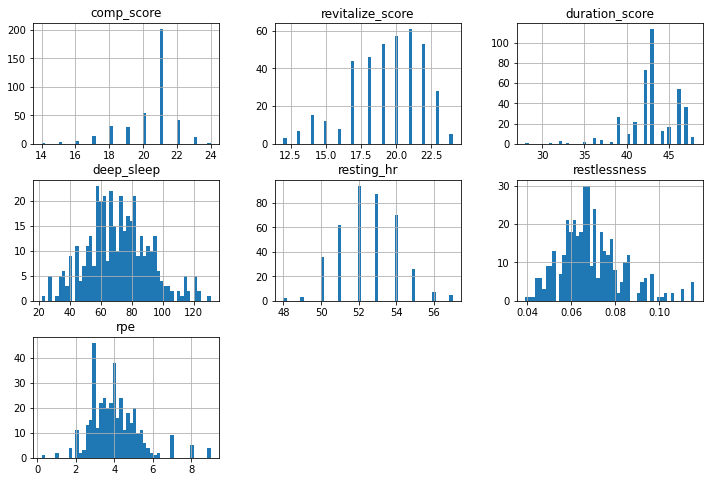

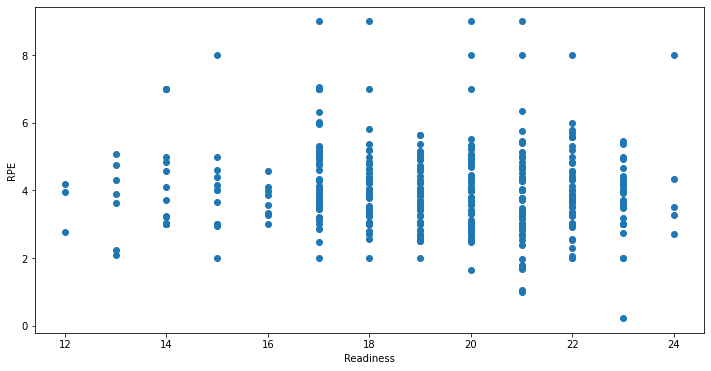

     comp_score  revitalize_score  duration_score  deep_sleep  resting_hr  \
2            22                22              43          96          57   
54           19                18              47         104          55   
74           21                20              43          78          55   
120          21                17              43          55          53   
187          21                24              42          73          54   
243          21                21              43          62          52   
315          21                20              46          73          50   
341          21                21              43          52          52   
391          21                15              43          72          48   

     restlessness  rpe  
2        0.061350  8.0  
54       0.059801  9.0  
74       0.084112  8.0  
120      0.075472  9.0  
187      0.060494  8.0  
243      0.064085  8.0  
315      0.058435  9.0  
341      0.070056  9.0  
391 

,comp_score,revitalize_score,duration_score,deep_sleep,resting_hr,restlessness,rpe
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,20.375000,19.334184,42.936224,71.456633,52.528061,0.068907,4.006547
std,1.513684,2.562379,2.962427,19.911522,1.594180,0.014093,1.270691
min,14.000000,12.000000,28.000000,22.000000,48.000000,0.039106,0.227725
25%,20.000000,18.000000,42.000000,58.000000,51.000000,0.060000,3.039836
50%,21.000000,20.000000,43.000000,71.500000,52.000000,0.066889,3.892507
75%,21.000000,21.000000,45.000000,84.000000,54.000000,0.076138,4.694640
max,24.000000,24.000000,48.000000,131.000000,57.000000,0.116041,9.000000


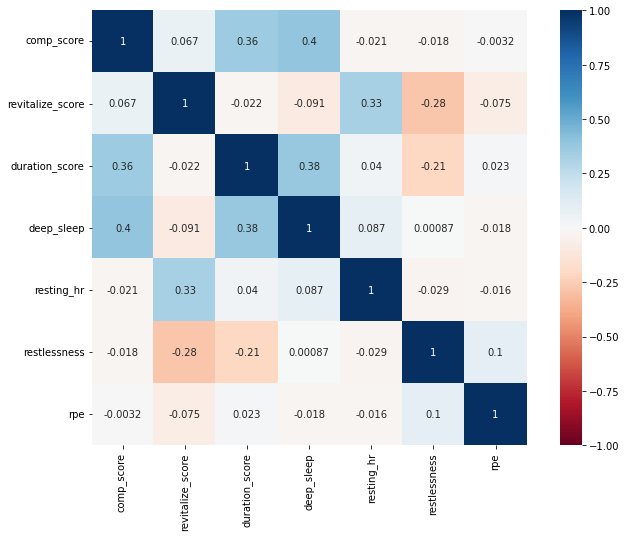

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#histplot
data.hist(bins=50, figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(data['revitalize_score'], data['rpe'])
ax.set_xlabel('Readiness')
ax.set_ylabel('RPE')
plt.show()

# Z score
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.999)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
# data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

# correlation matrix
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(data.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

data.describe()

Data Prep => Multicollinearity

In [37]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=30, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        # I'm going to set it to 20 and see what happens
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            try:
                vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
                max_vif = max(vif)
                if max_vif > thresh:
                    maxloc = vif.index(max_vif)
                    print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                    X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                    dropped=True
            except ValueError:  #raised if `vif` is empty.
                pass
        return X

# Remove columns having higher VIF factor that have high multicollinearity
# multicollinearity = ReduceVIF()
# data = multicollinearity.fit_transform(data)
# print(data.columns)

DU => pairplot RPE

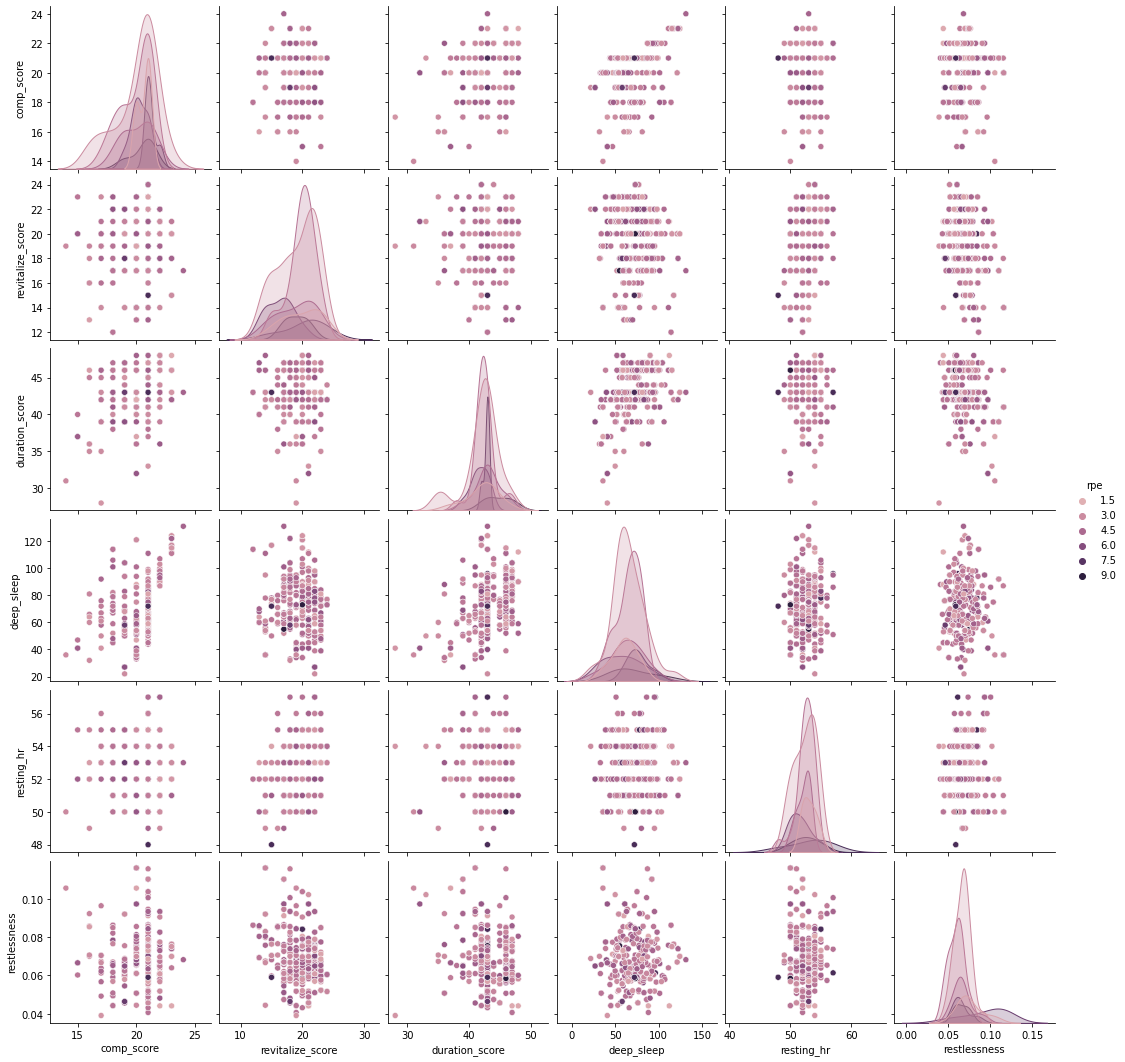

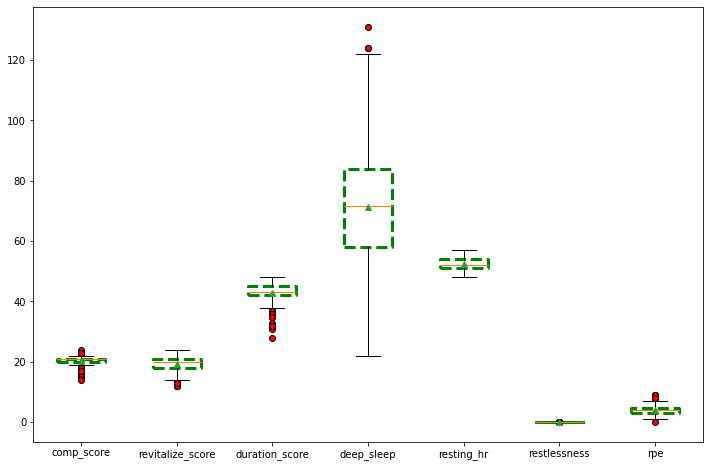

In [38]:
# pairplot with hue rpe
sns.pairplot(data, hue ='rpe')
plt.show()

#visualizing distributions 
fig, ax = plt.subplots(figsize=(12,8))
ticks = range(1, len(data.columns)+1)
labels = list(data.columns)
boxprops = dict(linestyle='--', linewidth=3, color='green')
flierprops = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
plt.boxplot(data.transpose(), showmeans=True, boxprops=boxprops, flierprops=flierprops)
plt.xticks(ticks,labels)
plt.show()

PCR Model += Feature Engineering => pre-processing, dimension reduction

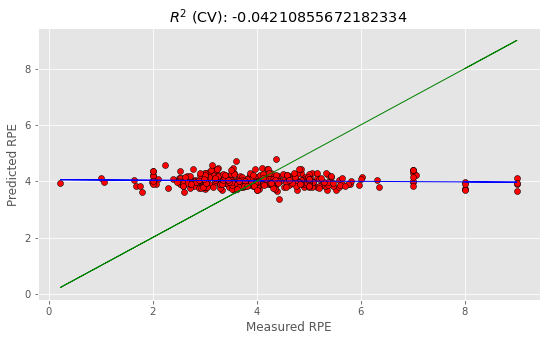

1.63 MSE


In [39]:
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, RFE, f_classif, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score

# separate the independent and dependent variables
X = data.loc[:, data.columns != 'rpe']
y = data.loc[:, data.columns == 'rpe']
# X = sm.add_constant(X)

# for future piping
numeric_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])


def pcr(X,y,pc):
  ''' Principal Component Regression in Python'''
  ''' Step 1: PCA on input data'''
  
  # Define the PCA object
  pca = PCA()
  
  # Preprocess: Standardize features by removing the mean and scaling to unit variance
  Xstd = StandardScaler().fit_transform(X)
  
  # Run PCA producing the reduced variable Xred and select the first pc components
  Xreg = pca.fit_transform(Xstd)[:,:pc]
  
  ''' Step 2: regression on selected principal components'''
  
  # Create linear regression object
  regr = lm.LinearRegression()
  
  # Fit
  regr.fit(Xreg, y)
  
  # Calibration
  y_c = regr.predict(Xreg)
  
  # Cross-validation
  y_cv = cross_val_predict(regr, Xreg, y, cv=10)
  
  # Calculate scores for calibration and cross-validation
  score_c = r2_score(y, y_c)
  score_cv = r2_score(y, y_cv)
  
  # Calculate mean square error for calibration and cross validation
  mse_c = mean_squared_error(y, y_c)
  mse_cv = mean_squared_error(y, y_cv)
  
  return(y_cv, score_c, score_cv, mse_c, mse_cv)

predicted, r2r, r2cv, mser, mscv = pcr(X,y, pc=6)

arr_y = np.array(y['rpe'])
# Regression plot
z = np.polyfit(arr_y, predicted, 1)
with plt.style.context(('ggplot')):
  fig, ax = plt.subplots(figsize=(9, 5))
  ax.scatter(arr_y, predicted, c='red', edgecolors='k')
  ax.plot(arr_y, z[1]+z[0]*y, c='blue', linewidth=1)
  ax.plot(arr_y, arr_y, color='green', linewidth=1)
  plt.title('$R^{2}$ (CV): '+str(r2cv))
  plt.xlabel('Measured RPE')
  plt.ylabel('Predicted RPE')
  plt.show()

# Define the parameter(s) range
parameters = {'pca__n_components': np.arange(1,6,1)} # all 6 features
pcr_pipe = Pipeline([('pca', PCA() ), ('linear_regression', lm.LinearRegression())])
pcr = GridSearchCV(pcr_pipe, parameters, scoring = 'neg_mean_squared_error')
 
pcr.fit(X, y)
# print(pcr.best_estimator_)
# print(pcr.best_score_)
pcr.best_estimator_.fit(X, y)
print("%0.2f MSE" % (-pcr.best_score_))

PLS Model

100% completed
Suggested number of components:  1



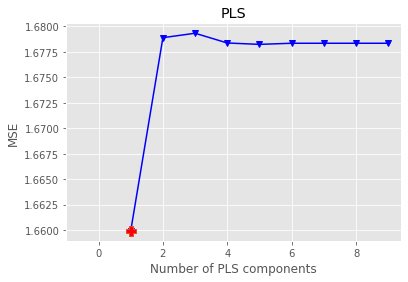

R2 calib: 0.014
R2 CV: -0.031
MSE calib: 1.588
MSE CV: 1.660


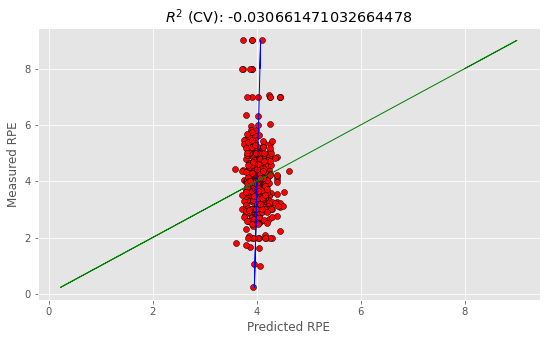

In [40]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout

def optimize_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/10
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    # rangey = max(y) - min(y)
    # rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    arr_y = np.array(y['rpe'])
    z = np.polyfit(arr_y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted RPE')
        plt.ylabel('Measured RPE')
 
        plt.show()
 
    return

optimize_pls_cv(X,y, 10, plot_components=True)    

Modeling => Tune hyperparams & layers += pipe thru Regression MLP

In [46]:
try:
    import scikeras
except ImportError:
    !pip install scikeras

try:
    import bayes_opt
except ImportError:
    !pip install bayesian-optimization


from scikeras.wrappers import KerasRegressor
from bayes_opt import BayesianOptimization
from typing import Dict, Iterable, Any
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.constraints import MaxNorm
LeakyReLU = LeakyReLU(alpha=0.1)

# Silence TensorFlow logging to keep output succinct.
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

# separate the independent and dependent variables
X = data.loc[:, data.columns != 'rpe']
y = data.loc[:, data.columns == 'rpe']
# X = sm.add_constant(X)

# split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# xtrain = X_train.values.reshape(X_train.size,1)
# xtrain = X_train.astype(np.float64, copy=False)

# ytrain = y_train.values.reshape(y_train.size,1)
# ytrain = y_train.astype(np.float64, copy=False)

# xtest = X_test.values.reshape(X_test.size,1)
# xtest = X_test.astype(np.float64, copy=False)

# print(np.isnan(xtrain).any(), np.isnan(ytrain).any(), np.isnan(xtest).any())
# print(np.isinf(xtrain).any(), np.isinf(ytrain).any(), np.isinf(xtest).any())

# print('Train set shape\n',X_train.shape, y_train.shape)
# print('Test set shape\n',X_test.shape, y_test.shape)

# Make scorer neg mse
neg_mean_squared_error_scorer = make_scorer(mean_squared_error,
                                        greater_is_better=False)

# Create function for tuning the NN hyperparameters and layers.
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate,clipnorm = 1.0), 'SGD':SGD(lr=learning_rate, clipnorm = 1.0),
                 'RMSprop':RMSprop(lr=learning_rate, clipnorm = 1.0), 'Adadelta':Adadelta(lr=learning_rate, clipnorm = 1.0),
                 'Adagrad':Adagrad(lr=learning_rate, clipnorm = 1.0), 'Adamax':Adamax(lr=learning_rate, clipnorm = 1.0),
                 'Nadam':Nadam(lr=learning_rate, clipnorm = 1.0), 'Ftrl':Ftrl(lr=learning_rate, clipnorm = 1.0)}
        
    activationL = ['relu', LeakyReLU]
        
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
        
    def nn_reg_fn():
        opt = Adam(lr = learning_rate, clipnorm = 1.0) # clipnorm fixed my exploding gradient error 
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=3, activation=activation, kernel_initializer='he_normal'))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation, kernel_initializer='he_normal'))
            nn.add(BatchNormalization())
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation, kernel_initializer='he_normal'))
            nn.add(BatchNormalization())
        nn.add(Dense(1, activation='relu'))
        nn.compile(loss='mse', optimizer=opt, metrics=[MeanSquaredError()])
        return nn
        
    es = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=10)
    nn = KerasRegressor(build_fn=nn_reg_fn, epochs=epochs, batch_size=batch_size, verbose=0)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=neg_mean_squared_error_scorer, cv=kfold, fit_params={'callbacks':[es]}).mean()
    # The function returns -model.rmse() because the optimizer by default is designed to maximize functions
    return -score

params_nn2 ={
    'neurons': (3, 10),
    'activation':(0, 1),
    'optimizer': (0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(64, 128),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0.1,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=5, n_iter=25)

params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', LeakyReLU,]
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
print(params_nn_)


class MLPRegressor(KerasRegressor):

    def __init__(
        self,
        neurons=params_nn_['neurons'],
        activation=params_nn_['activation'],
        k_init='he_normal',
        optimizer=params_nn_['optimizer'], #'adam'
        optimizer__learning_rate=learning_rate,#0.01
        optimizer__clipnorm=1, # fix gradient exploding
        batch_size=params_nn_['batch_size'],
        epochs=params_nn_['epochs'],
        l1 = params_nn_['layers1'],
        l2 = params_nn_['layers2'],
        norm = params_nn_['normalization'],
        dropout = params_nn_['dropout'],
        dropout_rate = params_nn_['dropout_rate'],
        verbose=False,
        callbacks=[EarlyStopping(monitor='mse', mode='min', verbose=0, patience=20)],
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.neurons = neurons
        self.activation = activation
        self.k_init = k_init
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.l1 = l1
        self.l2 = l2
        self.norm = norm
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.verbose = verbose  

    # BUild our regression model with optimized hyperparams & layers!
    def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):
        nn = Sequential()
        inp = Input(shape=(self.n_features_in_))
        nn.add(inp)
        nn.add(BatchNormalization())
        nn.add(Dense(self.neurons, input_dim=self.n_features_in_, activation=self.activation, kernel_initializer=self.k_init ))
        if self.norm > 0.5:
          nn.add(BatchNormalization())
        for i in range(self.l1):
          nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
          nn.add(BatchNormalization())
        if self.dropout > 0.5:
          nn.add(Dropout(self.dropout_rate, seed=123))
        for i in range(self.l2):
          nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
          nn.add(BatchNormalization())
        nn.add(Dense(1, activation='relu'))
        nn.compile(loss='mse', optimizer=self.optimizer, metrics=[MeanSquaredError()])
        return nn

# evaluate model with standardized dataset
pipe=Pipeline(steps=[('preprocessor', preprocessor),
                     ('estimator', MLPRegressor())])
pipe.fit(X_train, y_train)
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(pipe, X, y, cv=kfold, scoring='neg_mean_squared_error')
print("%0.2f MSE with a standard deviation between the folds of %0.2f" % (-results.mean(), results.std()))
#pipe.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

comp_score          False
revitalize_score    False
duration_score      False
deep_sleep          False
resting_hr          False
restlessness        False
dtype: bool rpe    False
dtype: bool comp_score          False
revitalize_score    False
duration_score      False
deep_sleep          False
resting_hr          False
restlessness        False
dtype: bool
comp_score          False
revitalize_score    False
duration_score      False
deep_sleep          False
resting_hr          False
restlessness        False
dtype: bool rpe    False
dtype: bool comp_score          False
revitalize_score    False
duration_score      False
deep_sleep          False
resting_hr          False
restlessness        False
dtype: bool
Train set shape
 (313, 6) (313, 1)
Test set shape
 (79, 6) (79, 1)
|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-----------------------------------------------------

ValueError: ignored

Modeling => prediction plots

In [ ]:
y_pred = pipe.predict(X_test)
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test,  s=6, label="y_test")
plt.scatter(x_ax, y_pred,  s=6, label="y_pred")
plt.plot(x_ax, y_test, label="y_test")
plt.plot(x_ax, y_pred, label="y_pred")
plt.legend()
plt.show()

Model Evaluation:

The data analysis began by exporting the data in CSV format then preparing the data by joining the files by date. The data cleaning steps included fixing outliers and extracting RPE from session notes and formatting it as float.

After the data understanding, it was clear we had some multicollinearity issues to fix. After running the VIF function we dropped down to four viable features. 

In [ ]:
import statsmodels.api as sm
# del y_pred

model = sm.OLS( y_train,X_train).fit()
# print(model.summary())

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

In [ ]:
y_pred = model.predict(X_test)
plt.plot(y_test, y_pred,'bo', label = 'Real data')
plt.plot([1,10], [1,10], color = 'blue', label = 'Perfect prediction')
plt.title('Prediction')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.legend()
plt.show()